In [1]:
#import modules 
import requests 
import base64
import json
import pandas as pd
from pandas.io.json import json_normalize
from pandas import Series
from matplotlib import pyplot as plt
import datetime



/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Import sampled data from a temp sensor

In [6]:
df = pd.read_csv('./tempSensor.csv', index_col=0)
print(len(df))
df.head(2)


8379


,temp,time
0,22.86,2018-06-01 17:50:58.339
1,21.84,2018-06-01 18:19:58.318


# Extract features, build dataset

In [20]:

sample=[]
sample_time=[]
sample_index=[]
sample_y=[]
counter = 0
negatives = []

# Greedy algorithm to extract our required samples. In this case a machine heats up the environment 
# We want to see if we can train a model to detect this specific machine. 
#We also build negative dataset taking the following 6 features. Looks random enough for this experiment

#The pattern we look in this dataset is 6 points long with a peak at the 3th point.
#       x
#         x
#     x     x  x
#   x

for x in range (3,8375):
    if df['temp'][x] >= df['temp'][x-2]+1.5 and df['temp'][x+1] < df['temp'][x]:
        example = [df['temp'][x-2:x+3]]
        sample.append(ex)
        sample_time.append(df['time'][x-2])
        sample_index.append(counter)
        sample_y.append('1')
        if(x < 8375 and x > 11):
            negatives.append([df['temp'][x-10:x-4]])
        counter=counter+1


# Now we have to manually check that each example is correct and remove bad ones or duplicates.                             
# Create Dataframe and manually remove bad examples using actual log.
df_raw = pd.DataFrame({'time': sample_time, 'col':sample,'nr':sample_index, 'y':'1'})
neg_df = pd.DataFrame({'col':negatives, 'y':'0'})
#new_df = df.drop(labels=[10,41,39,31,32,33,34,35,36,37,11,10,9,0])



In [21]:
print(df_raw.head(3))
print(neg_df.head(3))

                      time                                        col  nr  y
0  2018-06-04 16:19:36.220  [21.84, 22.82, 24.0, 23.72, 22.92, 22.44]   0  1
1  2018-06-29 05:58:29.066  [21.84, 22.82, 24.0, 23.72, 22.92, 22.44]   1  1
2  2018-07-04 19:57:34.167  [21.84, 22.82, 24.0, 23.72, 22.92, 22.44]   2  1
                                            col  y
0  [[22.86, 22.74, 22.74, 22.68, 22.74, 22.78]]  0
1  [[22.12, 22.02, 22.16, 22.06, 22.04, 21.98]]  0
2   [[21.42, 21.5, 21.46, 21.58, 21.58, 21.74]]  0


In [28]:
#Clean the dataframe and add nevatives
dataset = pd.concat([df_raw['col'], df_raw['y']],axis=1)
dataset = dataset.append(neg_df)
dataset.reset_index(drop=True, inplace=True)

#Store dataset to disk
#dataset.to_pickle('./datasets/machine/Timeseries_sensor_2018-09-02') 


### Here we add false positives from previous training. We also remove equal amount of negatives from dataset in 
### order to balance the dataset

In [7]:

true_neg = [[19.72, 20.08, 21.12, 20.64, 20.72, 20.64],[22.0, 22.06, 22.56, 21.52, 21.18, 20.9],
            [20.04, 20.64, 20.98, 19.86, 20.28, 20.5],[19.82, 19.76, 21.44, 20.12, 19.88, 19.94],
            [18.86, 18.88, 20.94, 20.0, 19.58, 19.5],[20.54, 20.62, 22.24, 20.64, 19.86, 20.0],
            [20.0, 21.42, 21.82, 20.6, 21.18, 20.66],[19.96, 20.34, 21.72, 21.18, 21.28, 20.48],
            [19.66, 19.58, 20.52, 20.08, 19.7, 19.54]]

#[18.86, 18.88, 20.94, 20.0, 19.58, 19.5],
            #[18.86, 21.32, 21.36, 19.62, 19.32, 19.2],[18.74, 18.72, 20.74, 20.12, 19.74, 19.96]

true_neg_y = [0,0,0,0,0,0,0,0,0]
new_neg = pd.DataFrame({'col':true_neg,'y':true_neg_y}).astype(object)
new_neg['y'] = new_neg['y'].astype(object)



In [29]:
len(dataset)

270

In [32]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

#Splid dataset in to test/train
X_train, X_test, y_train, y_test = train_test_split(list(dataset.col), dataset.y.values.astype('int'), test_size=0.3,random_state=109) 
print(y_train)
#Nomralize data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

#MinMax Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.fit_transform(X_test)

#Train model
clf = svm.SVC(kernel='rbf',probability=True)
clf.fit(X_train_transformed, y_train)

#Train model Min Max
clf_minMax = svm.SVC(kernel='rbf',probability=True)
clf_minMax.fit(X_train_minmax, y_train)

#Predict
score_trans = clf.score(X_test_transformed, y_test)  
y_pred = clf.predict(X_test_transformed)
y_prob = clf.predict_proba(X_test_transformed)
y_prov_minMax = clf_minMax.predict_proba(X_test_minmax)

[1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0
 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1
 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1
 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1
 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1
 0 0 0 0]


ValueError: setting an array element with a sequence.

### SVM validation 

In [14]:
#Metrics
scores = cross_val_score(clf, X_test_transformed, y_test, cv=5,scoring='recall_macro')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9130434782608695


In [15]:
from sklearn.metrics import precision_score, recall_score, make_scorer
import numpy as np
# Precision
precision_scorer = make_scorer(precision_score, pos_label=1)
precisions = cross_val_score(clf, X_train_transformed, y_train, cv=5, scoring=precision_scorer)
print ('Precision', np.mean(precisions), precisions)

# Recall
recall_scorer = make_scorer(recall_score, pos_label=1)
recalls = cross_val_score(clf, X_train_transformed, y_train, cv=5, scoring=recall_scorer)
print ('Recalls', np.mean(recalls), recalls)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
clf.predict_proba(scaler.transform([[20, 21.42, 21.82, 20.6, 21.18, 20.66]]))

Precision 0.9636363636363636 [1.         1.         0.81818182 1.         1.        ]
Recalls 0.9055555555555556 [0.88888889 0.88888889 1.         0.75       1.        ]
Accuracy: 0.9130434782608695


array([[0.05563287, 0.94436713]])

In [473]:
#Test single features
sample_1 = min_max_scaler.transform([[29,33,33.38,33.12,32.22,31.06],[20.30,20.34,20.84,20.78,21.44,21.40]])
sample_transformed = scaler.transform([[18.18,18.3,18.28,17.9,17.9,17.86],[ 18.44,19.08,20.7,20.32,20.04,19.98]])
score = clf_minMax.predict_proba(sample_1)
print("%.2f" % score[0][1])
#clf.predict(sample_transformed) 

#X_test_minmax = min_max_scaler.transform([[ 18.44,19.08,20.7,20.32,20.04,19.98]])
#clf_minMax.predict_proba(X_test_minmax)



0.98


### Gradient boosting

In [ ]:
model = lightgbm.LGBMClassifier(objective='binary',
    random_state=0, bagging_fraction=0.5, 
    num_iterations=1000, learning_rate=0.01, early_stopping_rounds=50)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

### Tesf or rolling window prediction for whole peroiod. (6 slots) Whould store values above threshold.

In [2]:
day_score = []
window_size = 6
cutoff = 0.7
window = []
samples = []
samples_index = []
day= john_30d
prob= []

for hour in range (0,len(day)-5):
    #window = [day[x], day[x+1],day[x+2],day[x+3],day[x+4],day[x+5]]
    window = day[hour:hour+window_size]
    sample_t = scaler.transform([window])
    #prob = clf.predict_proba(sample_t)
    prob = tpot.predict_proba([window])
    if(prob[0][1] > cutoff):
        samples.append(window)
        samples_index.append([hour+2, day[hour+2]])
        day_score.append([prob])
        print(prob, hour+2, window)

#print(day_score[0][0][0][1])
result = samples[:]
result_index = samples_index[:]
final = []
final_i = []

print(result)

#Clean duplicates
for x in range(0,len(result_index)-1):
    if (result_index[x][0]+3 > result_index[x+1][0]):
        if (day_score[x][0][0][1] > day_score[x+1][0][0][1]):
            final.append(result[x])
            final_i.append(samples_index[x])
        elif (day_score[x][0][0][1] < day_score[x+1][0][0][1]):
            print("2", result[x+1])
            final.append(result[x+1])
            final_i.append(samples_index[x+1])
            
           
fig, axs = plt.subplots(1, len(final), figsize=(15,2), sharey=True)
for x in range(0,len(final)):
    axs[x].plot(final[x])

plt.figure(figsize=(18,7))
for x in range(0, len(final_i)):
    plt.plot(final_i[x][0], final_i[x][1], 'rd')
plt.plot(day)



NameError: name 'john_30d' is not defined

In [111]:
day_score = []
window_size = 8
cutoff = 0.6
window = []
samples = []
samples_index = []
day= victor_30d['temp']
prob= []

def get_peak(window):
    return window.index(max(window))

for hour in range (0,len(day)-5,6):
    #window = [day[x], day[x+1],day[x+2],day[x+3],day[x+4],day[x+5]]
    peak_index = (hour+get_peak(day[hour:hour+window_size]))
    
    window = day[peak_index-2:peak_index+4]
    if(peak_index < 3):
        window=day[peak_index:peak_index+6]
    #sample_t = scaler.transform([window])
    #prob = clf.predict_proba(sample_t)
    print(window)
    #prob = model.predict_proba([window])
    prob = tpot.predict_proba([window])
    print(prob)
    if(prob[0][1] > cutoff):
        samples.append(window)
        samples_index.append([peak_index, day[peak_index]])
        day_score.append([prob])
        print(prob, hour+2, window)

#print(day_score[0][0][0][1])
result = samples[:]
result_index = samples_index[:]
final = samples[:]
final_i = samples_index[:]

#Clean duplicates
"""
for x in range(0,len(result_index)-1):
    if result_index[x][0]+7 > (result_index[x+1][0]):
        if (day_score[x][0][0][1] > day_score[x+1][0][0][1]):
            print(result[x])
            final.append(result[x])
            final_i.append(samples_index[x])
        elif (day_score[x][0][0][1] < day_score[x+1][0][0][1]):
            final.append(result[x+1])
            final_i.append(samples_index[x+1])
    else:
        final.append(result[x])
        final_i.append(samples_index[x])
"""

fig, axs = plt.subplots(1, len(final), figsize=(15,2), sharey=True)
for x in range(0,len(final)):
    axs[x].plot(final[x])

plt.figure(figsize=(18,7))
for x in range(0, len(final_i)):
    plt.plot(final_i[x][0], final_i[x][1], 'rd')
plt.plot(day)


[19.6, 18.32, 17.76, 17.14, 16.66, 16.28]
[[0.99729198 0.00270802]]
[17.14, 16.66, 16.28, 15.88, 15.48, 15.3]
[[0.98918093 0.01081907]]
[15.52, 15.54, 15.4, 15.22, 15.08, 14.8]
[[0.96977881 0.03022119]]
[13.96, 15.52, 18.6, 18.84, 17.98, 17.46]
[[0.04395775 0.95604225]]
[[0.04395775 0.95604225]] 20 [13.96, 15.52, 18.6, 18.84, 17.98, 17.46]
[15.52, 18.6, 18.84, 17.98, 17.46, 16.92]
[[0.22444824 0.77555176]]
[[0.22444824 0.77555176]] 26 [15.52, 18.6, 18.84, 17.98, 17.46, 16.92]
[17.46, 16.92, 16.5, 16.24, 16.04, 15.78]
[[0.9906148 0.0093852]]
[15.7, 15.66, 15.58, 15.58, 15.32, 15.26]
[[0.96988991 0.03011009]]
[15.44, 15.46, 15.54, 15.52, 15.56, 15.52]
[[0.95952349 0.04047651]]
[15.56, 15.54, 15.58, 15.6, 15.52, 15.62]
[[0.96365741 0.03634259]]
[15.76, 15.76, 15.84, 15.74, 15.78, 15.7]
[[0.96082828 0.03917172]]
[15.76, 15.76, 15.84, 15.74, 15.78, 15.7]
[[0.96082828 0.03917172]]
[15.86, 15.9, 15.94, 15.96, 15.94, 15.98]
[[0.96090761 0.03909239]]
[15.98, 15.98, 16.04, 15.98, 16, 16.06]
[[0.

[[0.99387011 0.00612989]]
[17.2, 16.96, 16.74, 16.6, 16.52, 16.4]
[[0.98146414 0.01853586]]
[16.34, 16.28, 16.18, 16.18, 16.14, 15.94]
[[0.97182043 0.02817957]]
[15.56, 15.72, 15.98, 15.86, 15.66, 15.58]
[[0.93878825 0.06121175]]
[15.98, 15.86, 15.66, 15.58, 15.5, 15.44]
[[0.97706696 0.02293304]]
[15.3, 15.44, 15.54, 15.34, 15.42, 15.24]
[[0.95125309 0.04874691]]
[15.3, 15.44, 15.54, 15.34, 15.42, 15.24]
[[0.95125309 0.04874691]]
[15.1, 15, 14.88, 14.88, 14.88, 14.72]
[[0.97331323 0.02668677]]
[14.66, 14.64, 14.6, 14.54, 14.58, 14.46]
[[0.96669763 0.03330237]]
[14.28, 14.28, 14.44, 14.22, 14.18, 14.02]
[[0.95517457 0.04482543]]
[14.18, 14.02, 14.06, 13.96, 13.94, 14]
[[0.96893919 0.03106081]]
[14, 14.04, 14.12, 14.14, 14.16, 14.24]
[[0.95721993 0.04278007]]
[14.24, 14.2, 14.26, 14.24, 14.24, 14.38]
[[0.96266944 0.03733056]]
[14.5, 14.48, 15.46, 17.84, 18.68, 17.66]
[[0.87747898 0.12252102]]
[15.46, 17.84, 18.68, 17.66, 16.94, 16.54]
[[0.248931 0.751069]]
[[0.248931 0.751069]] 710 [15.4

ValueError: query data dimension must match training data dimension

## Plot timeserises
* Change y,xlim if needed

(18, 28)

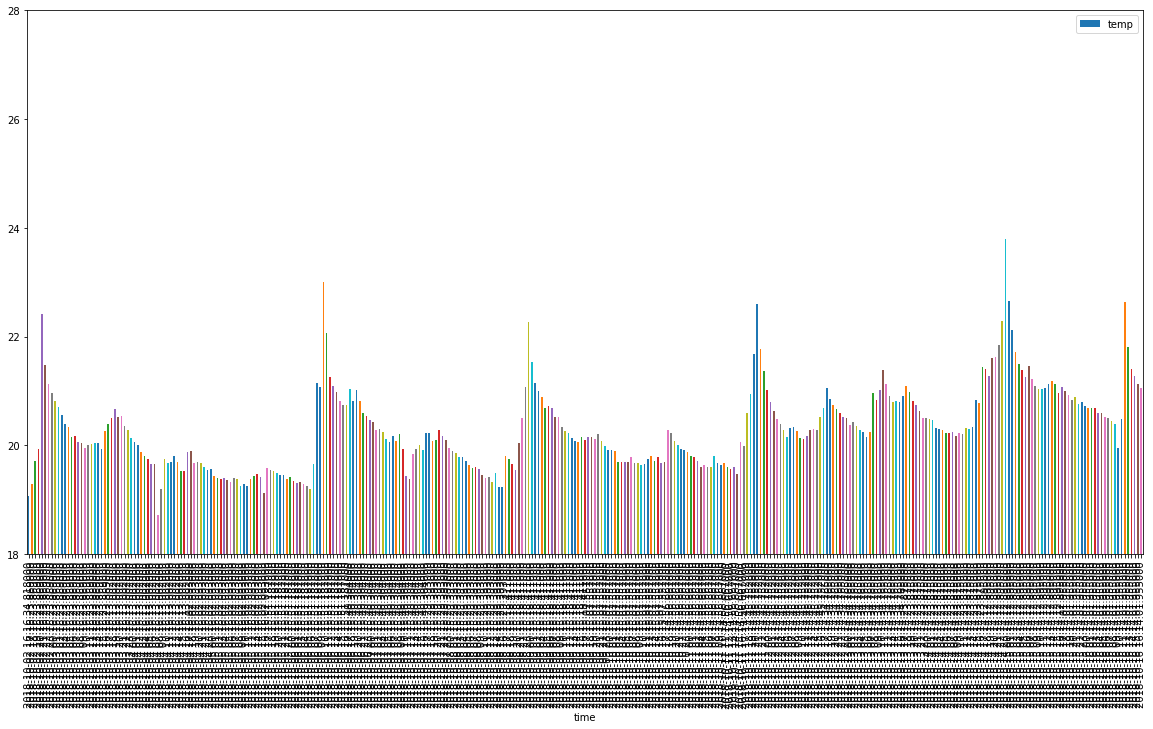

In [4]:

df.plot(x='time',y='temp',kind='bar', figsize=(20,10))
#plt.xlim(70,90)
plt.ylim(18,28)

#, style='.-',markevery=0

## Plot subset

(19.5, 24)

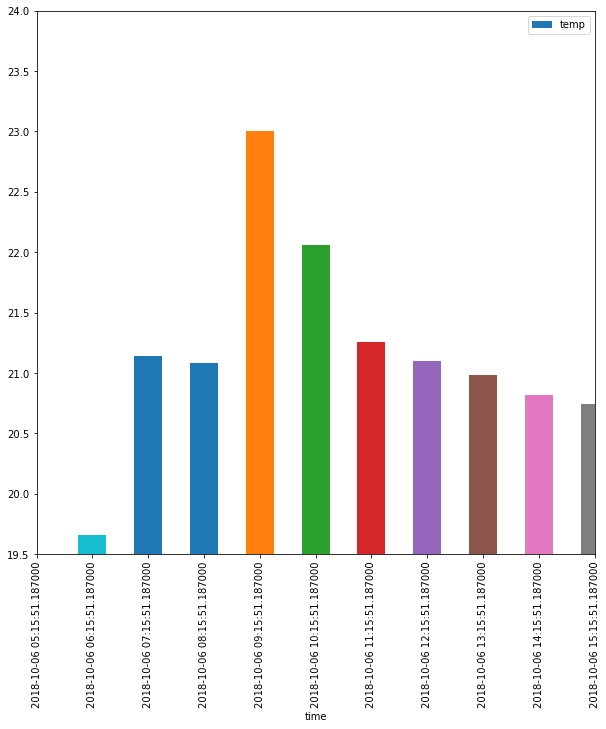

In [45]:

df.plot(x='time',y='temp',kind='bar', figsize=(10,10))
plt.xlim(85,95)
plt.ylim(19.5,24)

#, style='.-',markevery=0